In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

### READING animelist.csv

In [2]:
import os

In [3]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [4]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory=True, usecols=['user_id','anime_id','rating'])

In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
len(rating_df)

5000000

### DATA PROCESSING

In [7]:
n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings>=400].index)].copy()

In [8]:
len(rating_df)

3246641

In [9]:
min_rating = min(rating_df['rating'])
min_rating

0

In [10]:
max_rating = max(rating_df['rating'])
max_rating

10

In [11]:
avg_rating = np.mean(rating_df['rating'])
avg_rating

np.float64(4.122732695114736)

In [12]:
rating_df['rating']=rating_df['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [13]:
avg_rating = np.mean(rating_df['rating'])
avg_rating

np.float64(0.4122732695114729)

In [14]:
max_rating = max(rating_df['rating'])
max_rating

1.0

In [15]:
min_rating = min(rating_df['rating'])
min_rating

0.0

In [16]:
rating_df.duplicated().sum()

np.int64(0)

In [17]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [18]:
user_ids = rating_df['user_id'].unique().tolist()
user2user_encoded = {x : i for i,x in enumerate(user_ids)}
user2user_decoded = {i : x for i,x in enumerate(user_ids)}
rating_df['user'] = rating_df['user_id'].map(user2user_encoded)

In [19]:
n_users = len(user2user_encoded)
n_users

4203

In [20]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoded = {x : i for i,x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i,x in enumerate(anime_ids)}
rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encoded)

In [21]:
n_anime = len(anime2anime_encoded)
n_anime

17149

In [22]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [23]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239
3,15851,37491,0.0,4024,1813
4,1596,29803,0.9,415,353


In [24]:
X = rating_df[['user','anime']].values
y = rating_df['rating']

In [25]:
test_size = 15000
train_indices = rating_df.shape[0] - test_size

In [26]:
X_train , X_test , y_train , y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]

)

In [27]:
len(X_train),len(X_test),len(y_train),len(y_test)

(3231641, 15000, 3231641, 15000)

In [28]:
type(X_train)

numpy.ndarray

In [29]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [30]:
type(X_test_array)

list

In [31]:
type(X_test_array[0])

numpy.ndarray

### MODEL ARCHITECTURE

In [32]:
def RecommenderNet():
    embedding_size =128

    user = Input(name="user",shape=[1])

    user_embedding = Embedding(name="user_embedding",input_dim=n_users,output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])

    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name="dot_product" , normalize=True , axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer='Adam')
    return model

In [33]:
model = RecommenderNet()

In [34]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [35]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 7500

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [36]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)


In [37]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [38]:
history=model.fit(
    x = X_train_array,
    y = y_train,
    batch_size = batch_size,
    epochs = 20,
    verbose = 1,
    validation_data = (X_test_array, y_test),
    callbacks = my_callbacks
)

Epoch 1/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.8007 - mae: 0.3821 - mse: 0.1973 - val_loss: 0.7600 - val_mae: 0.3754 - val_mse: 0.1843 - learning_rate: 1.0000e-05
Epoch 2/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.7967 - mae: 0.3807 - mse: 0.1958 - val_loss: 0.7966 - val_mae: 0.3821 - val_mse: 0.1966 - learning_rate: 1.8000e-05
Epoch 3/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.7897 - mae: 0.3780 - mse: 0.1930 - val_loss: 0.7942 - val_mae: 0.3816 - val_mse: 0.1958 - learning_rate: 2.6000e-05
Epoch 4/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.7802 - mae: 0.3743 - mse: 0.1891 - val_loss: 0.7890 - val_mae: 0.3804 - val_mse: 0.1939 - learning_rate: 3.4000e-05


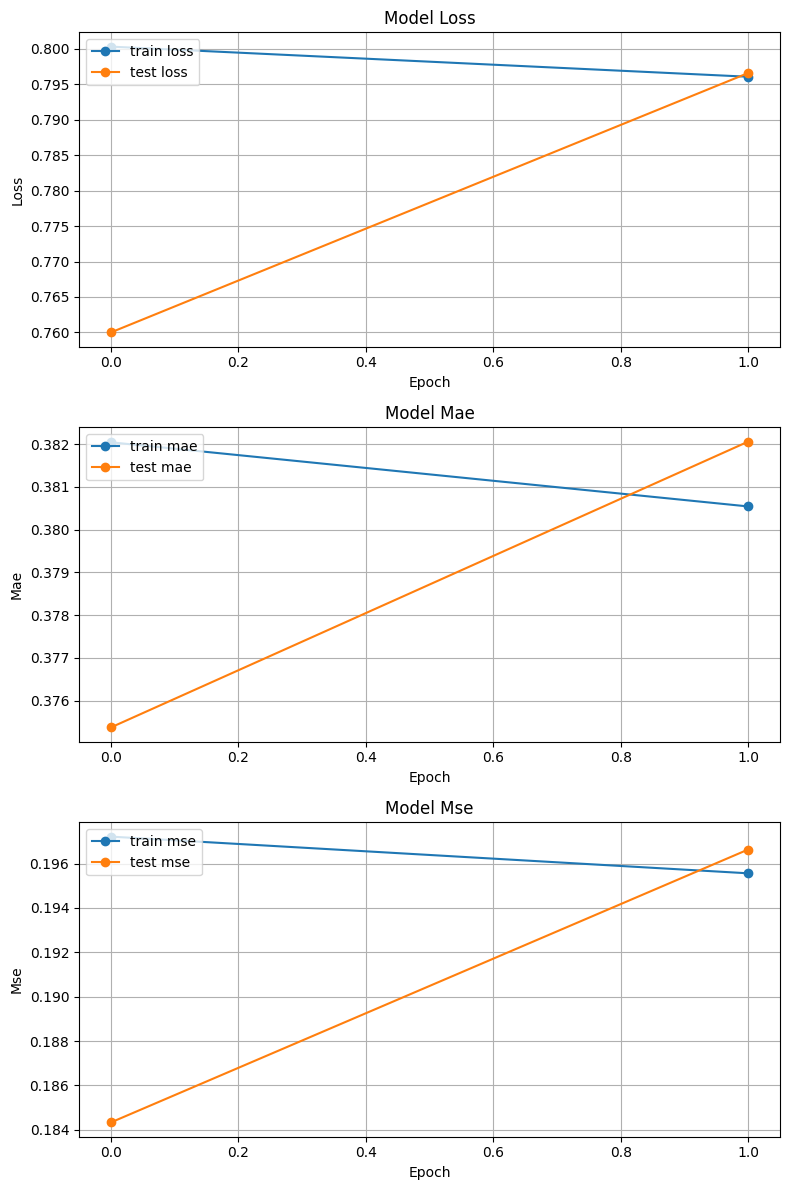

In [39]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [40]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [41]:
anime_weights = extract_weights("anime_embedding", model)

In [42]:
user_weights = extract_weights("user_embedding", model)

#### READING anime.csv

In [43]:
df = pd.read_csv(INPUT_DIR+'/anime.csv', low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [44]:
df = df.replace('Unknown', np.nan)

In [45]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
        return name
    except:
        print("Error")
        return None

In [46]:
df["anime_id"] = df['MAL_ID']
df['eng_version']=df['English name']
df['eng_version']=df.anime_id.apply(lambda x:getAnimeName(x))

In [47]:
getAnimeName(106)

'Hana Yori Dango'

In [48]:
df.sort_values(by=['Score'],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position='last')

In [49]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [50]:
df = df[['anime_id','eng_version','Score','Genres','Episodes','Type','Premiered','Members']]

In [51]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [52]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [53]:
getAnimeFrame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [54]:
getAnimeFrame("Attack on Titan Final Season",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


#### anime_with_synopsis.csv

In [55]:
cols = ['MAL_ID', 'Name','Genres','sypnopsis']

In [56]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

In [57]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [58]:
def getSynopsis(anime, synopsis_df):
    if isinstance(anime, int):
        result = synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values
    elif isinstance(anime, str):
        result = synopsis_df[synopsis_df.Name == anime].sypnopsis.values
    else:
        return None
    return result[0] if len(result) > 0 else None


In [59]:
getSynopsis(40028, synopsis_df)[0]

'G'

In [60]:
getSynopsis("Steins;Gate", synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### CONTENT/ITEM BASED RECOMMENDATION

In [61]:
pd.set_option("max_colwidth",None)

In [62]:
def find_similar_animes(name, anime_weights,anime2anime_encoded,
                        anime2anime_decoded,df,synopsis_df, n=10,return_dist=False,neg=False):
    
    try:
        index = getAnimeFrame(name,df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        weights = anime_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dist = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dist[:n]
        else:
            closest = sorted_dist[-n:]

        
        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for close in closest:
            decoded_id = anime2anime_decoded.get(close)

            anime_frame = getAnimeFrame(decoded_id, df)

            synopsis = getSynopsis(decoded_id,synopsis_df)

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]
            

            SimilarityArr.append({
                "anime_id" : decoded_id,
                "name" : anime_name,
                "similarity" : similarity,
                "genre" : genre,
                "synopsis":synopsis
            })

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(["anime_id"],axis=1)
    except:
        print("Error occured")


In [63]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    
)

,name,similarity,genre,synopsis
9,Shabura Rental: Ecchi na Oneesan to no Eroero Rental Obenkyou The Animation,0.315133,Hentai,None
8,Winds of Change,0.313004,"Fantasy, Kids","magical blending of old and new, with colorful animation and an exciting disco/rock musical score, ""Winds of Change"" is a re-telling of 5 ancient Greek myths. These delightful cautionary tales are adapted from the classical author, Ovid, with a new character, called Wondermaker added. Wondermaker acts as our guide to each episode's meaning, and transforms himself into each of its heroes. First, he is Perseus cutting off the head of Medusa; then, Actaeon being turned into a deer for spying on the goddess Diana as she bathes; the god Mercury in a tale of envy; Orpheus descending into Hades for his love, Eurydice; and finally, Phaeton wreaking havoc with the sun-god's chariot."
7,Meikoku Gakuen: Jutai-hen,0.310329,Hentai,None
6,Kitty to Mimmy no Happy Birthday,0.299298,"Kids, Fantasy",It's Kitty and Mimmy's birthday but no one seems to care. What surprise waits for them at the end of the day?
5,We Never Learn!:Bokuben,0.294638,"Harem, Comedy, Romance, School, Shounen","Under Nariyuki Yuiga's devoted tutelage, his classmates Rizu Ogata, Fumino Furuhashi, and Uruka Takemoto are finally pulling average test scores on their worst subjects. But time is ticking, and there is still a long way to go before the three geniuses of Ichinose Academy are ready for their upcoming university exams. Meanwhile, the girls still struggle to balance the pursuit of their dreams with their growing affections for their unsuspecting tutor. Joining them are Mafuyu Kirisu, a teacher with strong views about education and talent because of her past as a rising figure skater, and Asumi Kominami, a graduate from their school aiming to attend a national medical university. With these two additions, the group of six is livelier than ever before. Completely caught up in hilarious antics with his new friends, Yuiga finds that his last year of high school now includes a lot more than just going to class and studying."
4,Viva Namida,0.287248,Music,"usic video for Yasuyuki Okamura's song Viva Namida. It's also a promo for Space☆Dandy, animated television series produced by BONES."
3,Doolie Baenang-Yeohaeng,0.286283,"Adventure, Kids","Dooly and gang travel around the world, speaking English and making new friends. This educational video was made to capture the popular English learning boom that happened around its creation time. (Source: Cake-kun and AniDB)"
2,Mobile Suit SD Gundam Mk II,0.282897,"Mecha, Parody, Sci-Fi","obile Suit SD Gundam Mk II delivers with more tongue-in-cheek humor than the first series. In ""The Rolling Colony Affair,"" a colony is hosting a cabaret show featuring the girls of Gundam. But the show turns disastrous when men and mobile suits go crazy over the girls, sending the colony rolling out of control. A parody of the videogame RPG genre, ""Gundam Legend"" has Amuro, Kamille and Judau sent on a perilous quest to rescue the princess of the Zeta Kingdom from Char Aznable and his vicious Zeon MS forces. (Source: ANN)"
1,Co-eD Affairs,0.281695,Hentai,None
0,Otokonoko ♂ Delivery,0.276185,"Hentai, Yaoi",None


### USER BASED RECOMMENDATION SYSTEM

In [64]:
def find_similar_users(item_input , user_weights, user2user_encoded, user2user_decoded, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights
        
        dists = np.dot(weights, weights[encoded_index])
        sorted_dist = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dist[:n]
        else:
            closest = sorted_dist[-n:]

        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                    })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error occured: ",e)

In [65]:
find_similar_users(
    int(11880),
    user_weights,
    user2user_encoded,
    user2user_decoded
)

,similar_users,similarity
9,15129,0.305186
8,13000,0.304835
7,11277,0.283365
6,10317,0.275366
5,8436,0.269563
4,2980,0.262878
3,14780,0.262872
2,9475,0.258899
1,7212,0.255886
0,6980,0.253399


In [66]:
def showWordCloud(all_genres):
    geners_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(geners_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [67]:
from collections import defaultdict

In [68]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1
    
    if plot:
        showWordCloud(all_genres)
    return genres_list

In [69]:
rating_df.head(1)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377


In [70]:
def get_user_prefernces(user_id, rating_df, df, plot=False):
    
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentaile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentaile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by='rating', ascending=False).anime_id.values
    )

    anime_df_rows = df[df['anime_id'].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[['eng_version', 'Genres']]
    if plot:
        getFavGenre(anime_df_rows,plot)

    return anime_df_rows

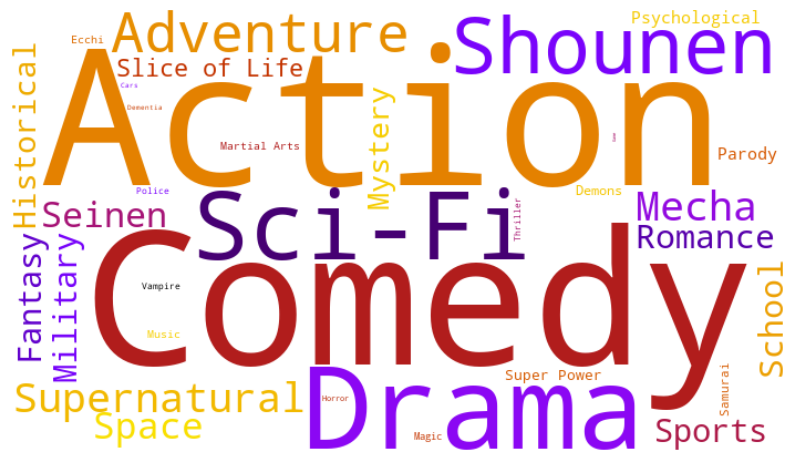

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [71]:
get_user_prefernces(11880, rating_df, df, plot=True)

In [72]:
def get_user_recommendation(similar_users, user_pref, df, synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = [] 

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_prefernces(int(user_id), rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
        anime_list = pd.DataFrame(anime_list)

        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i,anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

            if isinstance(anime_name,str):
                frame = getAnimeFrame(anime_name, df)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = getSynopsis(anime=int(anime_id),synopsis_df=synopsis_df)

                recommended_animes.append({
                    "n":n_user_pref,
                    "anime_name":anime_name,
                    "Genres":genre,
                    "Synopsis":synopsis
                })
    return pd.DataFrame(recommended_animes).head(n)    

In [73]:
similar_users = find_similar_users(
    int(11880),
    user_weights,
    user2user_encoded,
    user2user_decoded
)
similar_users

,similar_users,similarity
9,15129,0.305186
8,13000,0.304835
7,11277,0.283365
6,10317,0.275366
5,8436,0.269563
4,2980,0.262878
3,14780,0.262872
2,9475,0.258899
1,7212,0.255886
0,6980,0.253399


In [74]:
user_pref=get_user_prefernces(11880, rating_df, df, plot=False)

In [75]:
get_user_recommendation(
    similar_users,
    user_pref,
    df, 
    synopsis_df,
    rating_df,
    n=1
)

,n,anime_name,Genres,Synopsis
0,9,Attack on Titan,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached."


### Hybrid Recommender System

In [78]:
def hybrid_recommendation(user_id , user_weight=0.4, content_weight =0.6):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_prefernces(user_id , rating_df, df) 
    user_recommended_animes =get_user_recommendation(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 



In [79]:
hybrid_recommendation(int(11880))

['Attack on Titan', 'Mob Psycho 100', 'Steins;Gate', 'Clannad ~After Story~', 'Toradora!', 'One Piece', 'Made in Abyss', 'Re:ZERO -Starting Life in Another World-', 'Nisekoi:False Love', 'Magi:The Kingdom of Magic']


['K:SEVEN STORIES "Lost Small World - Outside the Cage - "',
 'Harukanaru Toki no Naka de 3: Kurenai no Tsuki',
 'Wild 7 Another',
 'Backkom Mission Impossible',
 'Majuu Senshi Luna Varga',
 'Aoi Yousei',
 'Gift±',
 'Television',
 'Nozomi Witches',
 'The Westward']